# 1.문제정의

캘리포니아 블록 그룹마다 인구, 중간 소득, 중간 주택 가격등을 갖고있는 데이터

**목적: 다른 측정 데이터가 주어졌을 때, 구역의 중간 주택 가격을 예측**

레이블 된 훈련샘플이 있으므로 지도 학습 작업<br/>
값 예측이 목적이므로 회귀, 예측에 사용할 특성이 여러개이므로 다중 회귀<br/>
각 구역마다 하나의 값을 예측하므로 단변량 회귀

빠르게 변화하는 데이터가 아니며, 데이터 용량이 작으므로 일반적인 배치 학습 진행

# 2. 성능 측정 지표 선택

회귀 문제의 전형적인 성능 지표: RMSE (평균 제곱근 오차)

RMSE는 MAE (평균 절대 오차)보다 조금 더 이상치에 민감
따라서 이상치가 많아 보이는 경우에는 MAE를 사용함

# 3. 데이터 로드

### 3.1 데이터 다운로드 및 호출 함수

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# 현재 작업공간에 datasets/housing 디렉터리 생성 및 다운로드, 압축해제
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

### 3.2 데이터 확인

In [5]:
fetch_housing_data()

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms은 null값이 존재

In [8]:
# ocean proximity만 object type
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


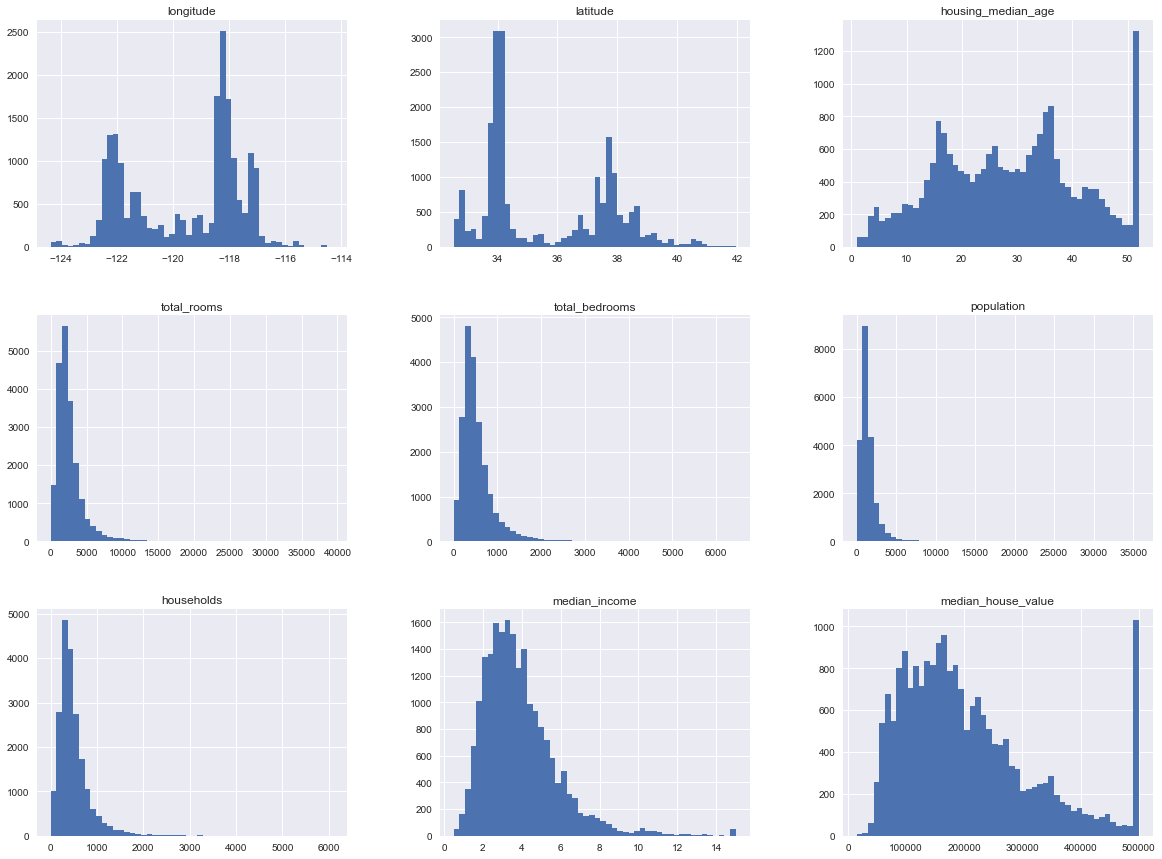

In [17]:
plt.style.use('seaborn')

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### 3.3 훈련, 테스트 데이터 셋 분리

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**계층적 샘플링**

설문조사 기관에서 1000명에게 질문을 하려 할때 무작위로 1000명을 뽑는 것이 아니라, 전체 인구를 대표할 수 있는 1000명을 선택하기 위해 노력한다. <br/>
미국 인구의 51.3%가 여성이고 48.7%가 남성이라면, 잘 구성된 설문조사는 샘플에서도 이 비율을 유지해서, 여성은 513명 남성은 487명이여야 한다.

중간 소득이 중간 주택 가격을 예측하는 데 중요하므로, 테스트 세트가 전체 데이터 세트에 있는 여러 소득 카테고리를 잘 대표해야 함

중간 소득은 연속형 피쳐이므로 소득에 대한 카테고리 특성을 만들어야함

In [14]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0. , 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

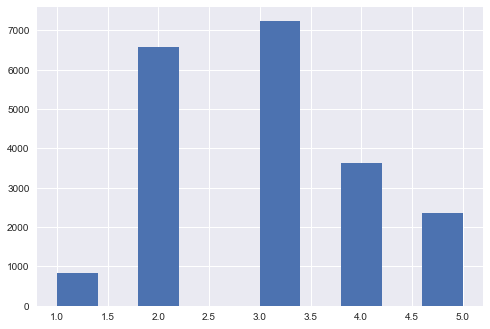

In [16]:
housing["income_cat"].hist()

In [18]:
# 소득 카테고리 기반으로 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [20]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

전체 데이터 셋과 테스트 세트의 소득 카테고리 비율이 비슷해졌다.

In [21]:
# 계층적 샘플링을 정상적으로 진행했으니, income_cat 피쳐 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 4. EDA 및 시각화

In [22]:
housing = strat_train_set.copy()

### 4.1 지리적 데이터 시각화

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

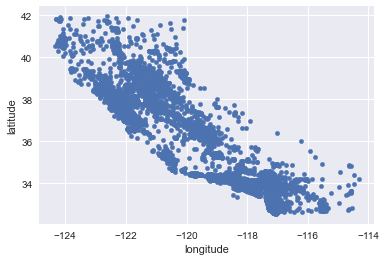

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

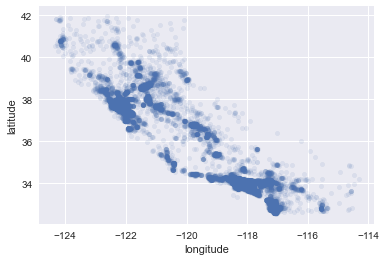

In [24]:
# 데이터 포인트 밀집도 확인
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

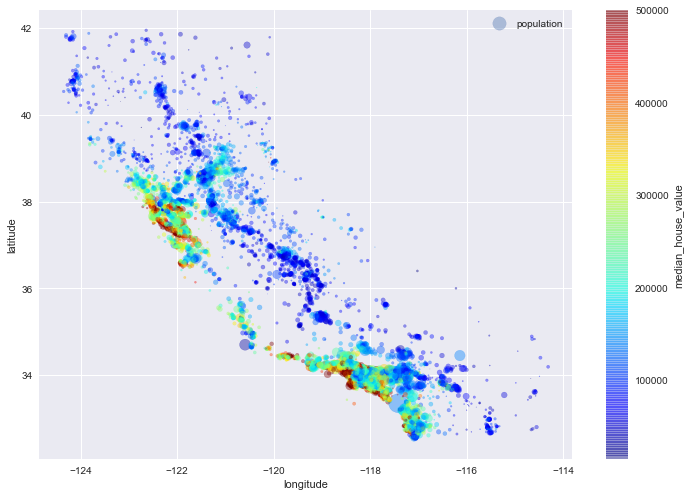

In [28]:
# 주택 가격
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            # 매개변수 s 마커의 크기: 원의 반지름은 구역의 인구
            s = housing['population']/100, label="population", figsize=(10,7),
            
            # 매개변수 c 색상: 색상은 가격
            c = "median_house_value", cmap=plt.get_cmap('jet'), colorbar=True,
            sharex=False)
plt.tight_layout()
plt.legend()

### 4.2 상관관계

데이터셋이 크지 않으므로 모든 특성간의 피어슨 corr을 계산

In [29]:
corr_matrix = housing.corr()

In [30]:
# 중간 주택 가격과 다른 특성 간의 상관관계
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

중간 주택 가격과 중간소득은 양의 상관관계<br/>
위도와 중간주택가격과는 약한 음의 상간관계 -- 북쪽으로 갈수록 주택 가격이 낮아지는 경향을 시각화에서 확인

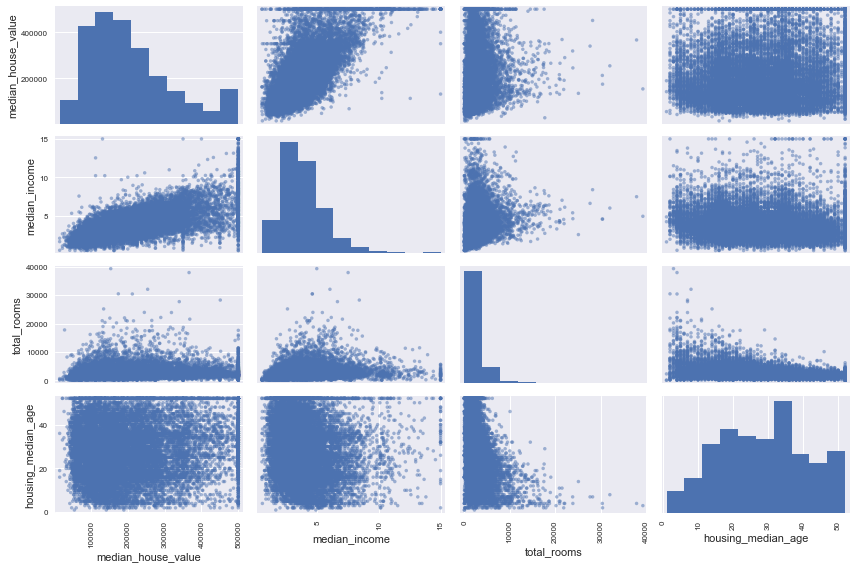

In [34]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

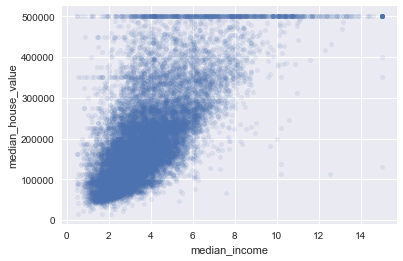

In [36]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [39]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [40]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

bedrooms_per_room 은 total_rooms(전체 방 개수)나 total_bedrooms(전체 침실 개수)보다 중간 주택 가격과의 상관관계가 더 높다.<br/>
침실/방의 비율이 낮은 집은 더 비싼 경향이 있음을 확인

rooms_per_household(가구 당 방 개수)도 total_rooms보다 유용<br/>
가구 당 방 개수도 큰 집이 더 비싼 경향이 있음을 확인

# 5. 데이터 전처리

In [43]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 5.1 수치형 데이터 전처리

In [44]:
# null 값 처리
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [45]:
# 수치형만 적용 가능하므로 object인 ocean_proximity는 제외한 복사본 생성
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [46]:
# SimpleImputer로 계산된 각 피쳐 중간값 확인
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [47]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [48]:
# 학습된 imputer 객체를 사용해 훈련 세트에서 누락된 값을 학습한 중간값으로 바꿈
X = imputer.transform(housing_num)

In [49]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [50]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### 5.2 텍스트와 범주형 데이터 전처리

In [53]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [56]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()

housing_cat_onehot = onehot_encoder.fit_transform(housing_cat)
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Sparse Matrix 형태임을 확인

넘파이 배열로 저장한다면 카테고리가 만을수록 열이 수천개가 되어 메모리 낭비이기 떄문

In [57]:
# 카테고리 목록 확인
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 5.3 피쳐 스케일링

정규화, 표준화

정규화는 0~1 범위에 들도록 설정

표준화는 평균 0, 분산 1
표준화는 이상치에 영향을 덜 받는다.

### 5.4 변환 파이프라인

변환 단계는 정확한 순서대로 실행되어야하므로 파이프라인을 생성

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
    
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

수치형과 범주형 피쳐 모두 스케일링 하는 파이프라인

In [62]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# 6. 모델 선택 및 훈련

### 6.1 train_Set 에서 훈련 및 평가

**선형 회귀 모델**

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [64]:
# 샘플 데이터에 적용 테스트
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]

In [65]:
some_data_prepared = full_pipeline.transform(some_data)
print("예측:", lin_reg.predict(some_data_prepared))
print("레이블: ", list(some_labels))

예측: [211574.39523833 321345.10513719 210947.519838    61921.01197837
 192362.32961119]
레이블:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [66]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.98178244587

과소 적합

과소적합을 해결하는 주요 방법은 더 강력한 모델을 택하거나, 훈련 알고리즘에 더 좋은 피쳐를 추가하거나, 모델의 규제를 감소시켜야 함

**DecisionTreeRegressor**

In [67]:
from sklearn.tree import DecisionTreeRegressor

# 모델 학습
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [68]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

너무 과대적합으로 보임

### 6.2 Cross Validation을 사용한 평가

In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

사이킷런 cross validation 기능은 scoring 매개변수에 낮을수록 좋은 비용함수가 아닌, 클수록 좋은 효용함수를 기대함

그래서 MSE의 반댓값을 계산하는 neg_mean_squared_error 함수를 사용한다.
따라서 -scores로 출력

In [71]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

In [72]:
display_scores(tree_rmse_scores)

점수: [67797.14088113 66482.02478515 72450.11394874 71163.88574921
 69140.73726309 74844.09486363 67552.61638555 68586.28559923
 69842.38810997 68800.43215245]
평균: 69665.97197381542
표준편차: 2390.1118399972984


교차 검증을 진행하였더니 오차가 69665 +- 2390 임을 확인함

선형회귀 모델도 똑같이 적용

In [73]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

점수: [67450.42057782 67329.50264436 68361.84864912 74639.88837894
 68314.56738182 71628.61410355 65361.14176205 68571.62738037
 72476.18028894 68098.06828865]
평균: 69223.18594556303
표준편차: 2657.268311277697


결정트리모델이 과대적합되어 선형회귀보다 성능이 안좋음

**RandomForestRegressor**

In [74]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [75]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

점수: [48195.39606909 45934.7507716  48933.20018272 49831.3608151
 49376.39970812 53392.09097304 48620.84538175 50540.61471972
 51492.82511521 49794.62855921]
평균: 49611.211229556306
표준편차: 1892.0352814894138


살짝 과대적합으로 보인다.

과대적합을 해결하는 방법은 모델을 간단히 하거나, 규제를 걸거나, 더 많은 훈련데이터를 모아야한다

실험한 모델을 저장해두면 필요할 때 쉽게 모델을 복원할 수 있다.

In [77]:
#import joblib

#joblib.dump(my_model, "my_model.pkl")

# my_model_loaded = joblib.load("my_model.pkl")

# 7. 모델 세부 튜닝

### 7.1 그리드 탐색

In [80]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [81]:
# 최적 하이퍼파라미터
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

그리드 탐색 방법은 비교적 적은 수의 조합을 탐구할 때 유용함

그러나 하이퍼파라미터 탐색 공간이 커지면 **RandomizedSearchCV**를 사용하는 편이 더 좋음

### 7.2 피쳐 중요도

In [83]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.11030807e-01, 1.01707956e-01, 5.02636520e-02, 3.33095841e-02,
       2.73792237e-02, 4.00825186e-02, 2.50406488e-02, 4.26125091e-01,
       1.29526093e-02, 1.65270628e-01, 5.03969132e-05, 2.12494218e-03,
       4.66194131e-03])

In [85]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.42612509136086724, 'median_income'),
 (0.1652706281065469, 'INLAND'),
 (0.11103080714534071, 'longitude'),
 (0.10170795639763737, 'latitude'),
 (0.05026365203403256, 'housing_median_age'),
 (0.04008251863332122, 'population'),
 (0.03330958411034196, 'total_rooms'),
 (0.027379223704881734, 'total_bedrooms'),
 (0.02504064877340453, 'households'),
 (0.01295260933608193, '<1H OCEAN'),
 (0.00466194130687079, 'NEAR OCEAN'),
 (0.002124942177514517, 'NEAR BAY'),
 (5.039691315870734e-05, 'ISLAND')]

이 정보를 바탕으로 덜 중요한 특성을 제외할 수 있다.

### 7.3 테스트 세트로 최종 모델 평가

테스트 세트를 full_pipeline을 사용해 데이터를 변환하고, transform() 호출

In [88]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [89]:
final_rmse

47441.76887062941

### 7.4 오차의 신뢰구간 계산

In [91]:
from scipy import stats
confidence = 0.95 # 95% 신뢰구간
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45550.37129299, 49260.59827305])